In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from pandas.tools.plotting import parallel_coordinates
%matplotlib inline

In [101]:
train_data = pd.read_csv("../input/train.csv")
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [102]:
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]


In [103]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [104]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Clean data by dropping columns which we are not using for visualization

In [105]:
train_data.drop(['PassengerId','Ticket'], axis=1, inplace = True)


**Feature engineering** :  Name/Title


In [106]:
train_data["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [107]:
# Get Title from Name
train_title = [i.split(",")[1].split(".")[0].strip() for i in train_data["Name"]]
train_data["Title"] = pd.Series(train_title)
train_data["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [108]:
# Get Title from Name
test_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(test_title)
test["Title"].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

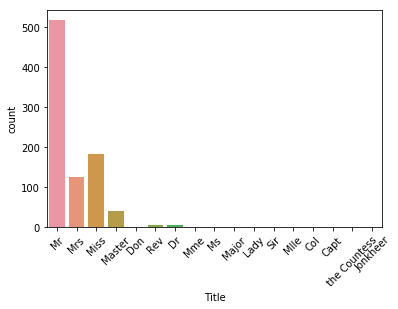

In [109]:
g = sns.countplot(x="Title",data=train_data)
g = plt.setp(g.get_xticklabels(), rotation=45) 


In [110]:
# Convert to categorical values Title 
train_data["Title"] = train_data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_data["Title"] = train_data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
train_data["Title"] = train_data["Title"].astype(int)

In [111]:
# Convert to categorical values Title 
test["Title"] = test["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test["Title"] = test["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
test["Title"] = test["Title"].astype(int)

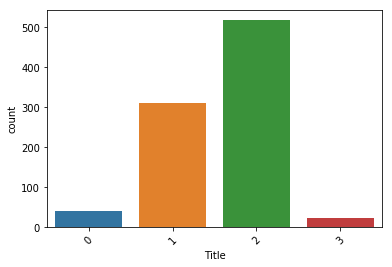

In [112]:
g = sns.countplot(x="Title",data=train_data)
g = plt.setp(g.get_xticklabels(), rotation=45) 


**Feature engineering** :  Family size

In [113]:
# Create a family size descriptor from SibSp and Parch
train_data["Family_size"] = train_data["SibSp"] + train_data["Parch"] + 1
test["Family_size"] = test["SibSp"] + test["Parch"] + 1


**Dealing with Missing Data**

missing data

In statistics, missing data, or missing values, occur when no data value is stored for the variable in an observation. Missing data are a common occurrence and can have a significant effect on the conclusions that can be drawn from the data. The goal of cleaning operations is to prevent problems caused by missing data that can arise when training a model.

Check wether data have null values or not

In [114]:
train_data.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
Title            0
Family_size      0
dtype: int64

In [115]:
#Fill Embarked nan values of dataset set with 'C' most frequent value
train_data["Embarked"] = train_data["Embarked"].fillna("C")
test["Embarked"] = test["Embarked"].fillna("C")

#complete missing fare with median
train_data['Fare'].fillna(train_data['Fare'].median(), inplace = True)
test['Fare'].fillna(test['Fare'].median(), inplace = True)

## Assigning all the null values as "N"
train_data.Cabin.fillna("N", inplace=True)
test.Cabin.fillna("N", inplace=True)

In [116]:
# group by Sex, Pclass, and Title 
grouped = train_data.groupby(['Sex','Pclass', 'Title'])  
# view the median Age by the grouped features 
grouped.Age.median()
# apply the grouped median value on the Age NaN
train_data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [117]:
# group by Sex, Pclass, and Title 
test_grouped = test.groupby(['Sex','Pclass', 'Title'])  
# view the median Age by the grouped features 
test_grouped.Age.median()
# apply the grouped median value on the Age NaN
test.Age = test_grouped.Age.apply(lambda x: x.fillna(x.median()))

Check whether all missing data are filled

In [118]:
train_data.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Title          0
Family_size    0
dtype: int64

In [67]:
train_data['survived_dead'] = train_data['Survived'].apply(lambda x : 'Survived' if x == 1 else 'Dead')

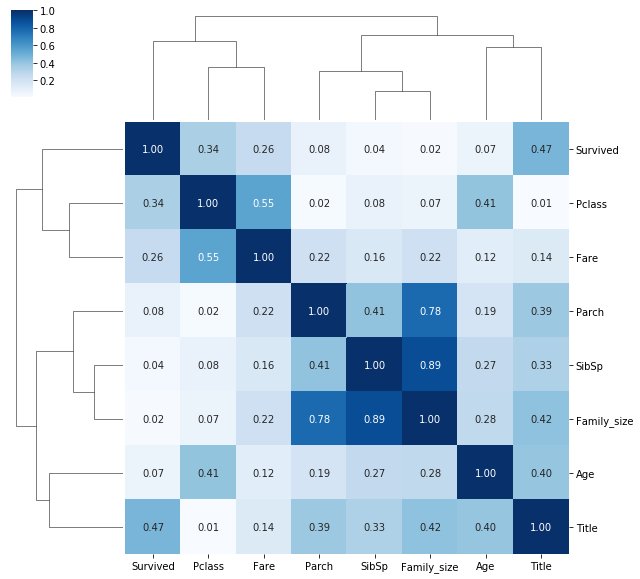

In [68]:
sns.clustermap(data = train_data.corr().abs(),annot=True, fmt = ".2f", cmap = 'Blues')

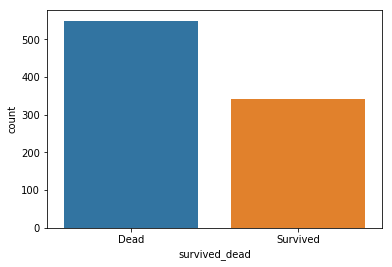

In [69]:
sns.countplot('survived_dead', data = train_data)

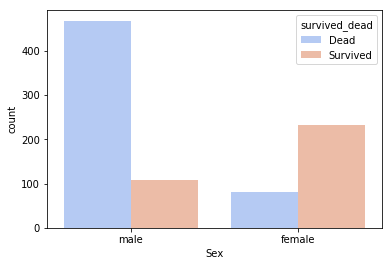

In [70]:
sns.countplot( train_data['Sex'],data = train_data, hue = 'survived_dead', palette='coolwarm')

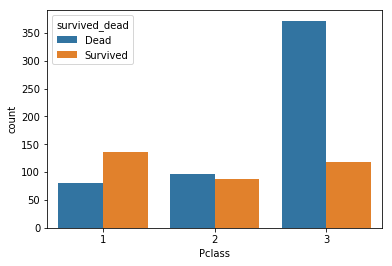

In [71]:
sns.countplot( train_data['Pclass'],data = train_data, hue = 'survived_dead')

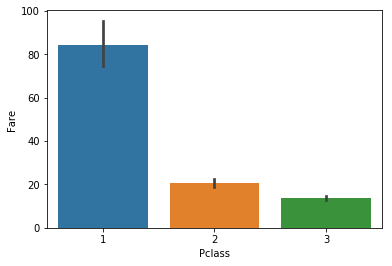

In [72]:
sns.barplot(x = 'Pclass', y = 'Fare', data = train_data)

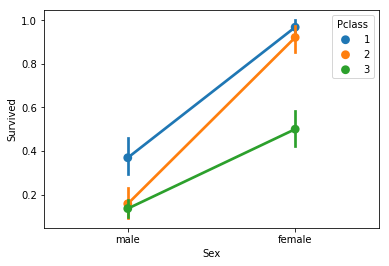

In [73]:
sns.pointplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = train_data);

Fare - Passenger Fare
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

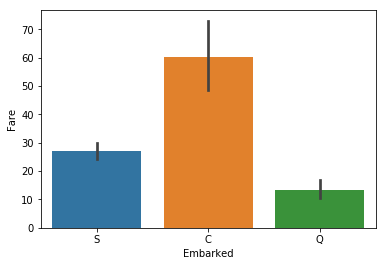

In [74]:
sns.barplot(x  = 'Embarked', y = 'Fare', data = train_data)

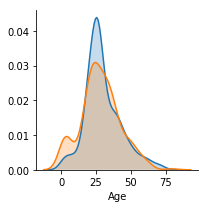

In [75]:
g = sns.FacetGrid(train_data, hue='Survived')
g.map(sns.kdeplot, "Age",shade=True)

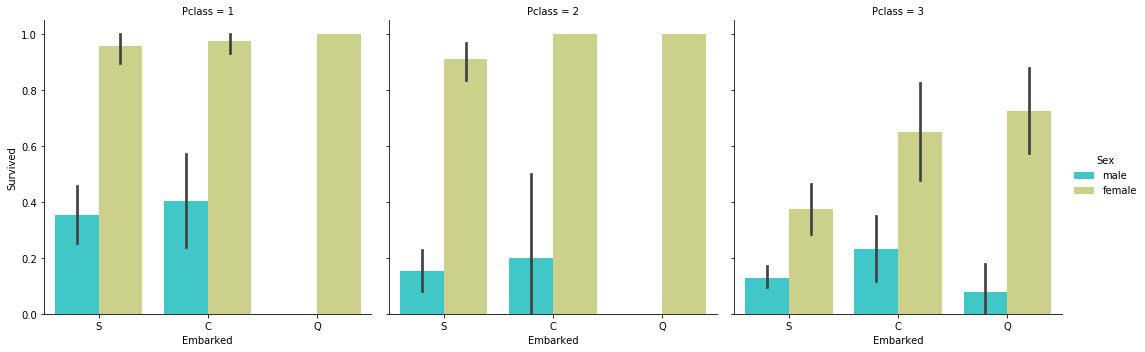

In [76]:
sns.catplot(x="Embarked", y="Survived", hue="Sex",
            col="Pclass", kind = 'bar',data=train_data, palette = "rainbow")

sibsp - Number of Siblings/Spouses Aboard



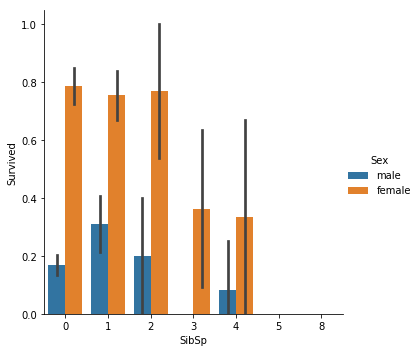

In [77]:
sns.catplot(x='SibSp', y='Survived',hue = 'Sex',data=train_data, kind='bar')

parch - Number of Parents/Children Aboard

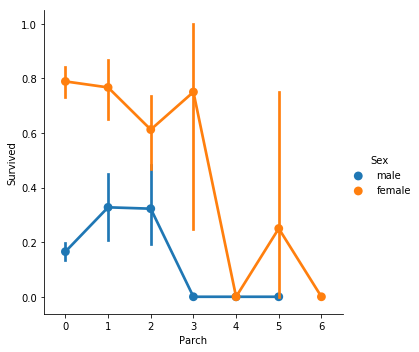

In [78]:
sns.catplot(x='Parch', y='Survived',hue = 'Sex',data=train_data, kind='point')

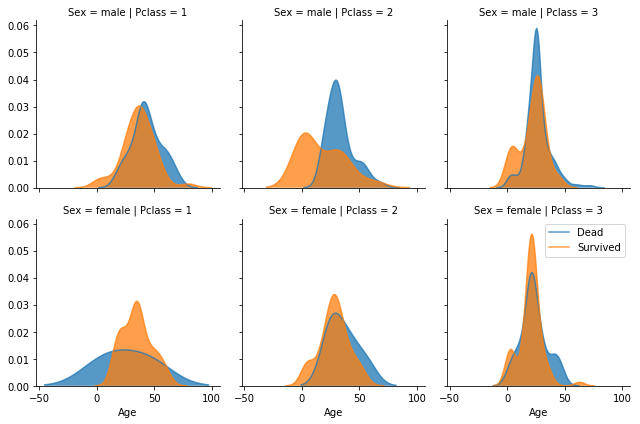

In [79]:
g= sns.FacetGrid(data = train_data, row = 'Sex', col = 'Pclass', hue = 'survived_dead')
g.map(sns.kdeplot, 'Age', alpha = .75, shade = True)
plt.legend()

In [80]:
categoricals = train_data.select_dtypes(exclude=[np.number])
categoricals.describe()

Name   Sex Cabin Embarked survived_dead
count                       891   891   891      891           891
unique                      891     2   148        3             2
top     Hodges, Mr. Henry Price  male     N        S          Dead
freq                          1   577   687      644           549

In [81]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

lbl = LabelEncoder() 
lbl.fit(list(train_data['Embarked'].values)) 
train_data['Embarked'] = lbl.transform(list(train_data['Embarked'].values))
lbl.fit(list(test['Embarked'].values)) 
test['Embarked'] = lbl.transform(list(test['Embarked'].values))

In [82]:
def encode(x): return 1 if x == 'female' else 0
train_data['enc_sex'] = train_data.Sex.apply(encode)
test['enc_sex'] = test.Sex.apply(encode)

In [83]:
train_data["has_cabin"] = [0 if i == 'N'else 1 for i in train_data.Cabin]
test["has_cabin"] = [0 if i == 'N'else 1 for i in test.Cabin]

In [84]:
from collections import Counter
# Outlier detection 

def detect_outliers(train_data,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(train_data[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(train_data[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = train_data[(train_data[col] < Q1 - outlier_step) | (train_data[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_data,2,["Age","SibSp","Parch","Fare"])


In [85]:
train_data.loc[Outliers_to_drop] # Show the outliers rows

Survived  Pclass                                           Name     Sex  \
268         1       1  Graham, Mrs. William Thompson (Edith Junkins)  female   
438         0       1                              Fortune, Mr. Mark    male   
587         1       1               Frolicher-Stehli, Mr. Maxmillian    male   
659         0       1                     Newell, Mr. Arthur Webster    male   
745         0       1                   Crosby, Capt. Edward Gifford    male   
27          0       1                 Fortune, Mr. Charles Alexander    male   
88          1       1                     Fortune, Miss. Mabel Helen  female   
159         0       3                     Sage, Master. Thomas Henry    male   
180         0       3                   Sage, Miss. Constance Gladys  female   
201         0       3                            Sage, Mr. Frederick    male   
324         0       3                       Sage, Mr. George John Jr    male   
341         1       1                 Fortune, Miss. Alice Elizabeth  female   
792         0       3                        Sage, Miss. Stella Anna  female   
846         0       3                       Sage, Mr. Douglas Bullen    male   
863         0       3              Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch      Fare        Cabin  Embarked  Title  Family_size  \
268  58.0      0      1  153.4625         C125         2      1            2   
438  64.0      1      4  263.0000  C23 C25 C27         2      2            6   
587  60.0      1      1   79.2000          B41         0      2            3   
659  58.0      0      2  113.2750          D48         0      2            3   
745  70.0      1      1   71.0000          B22         2      3            3   
27   19.0      3      2  263.0000  C23 C25 C27         2      2            6   
88   23.0      3      2  263.0000  C23 C25 C27         2      1            6   
159   4.0      8      2   69.5500            N         2      0           11   
180  21.5      8      2   69.5500            N         2      1           11   
201  26.0      8      2   69.5500            N         2      2           11   
324  26.0      8      2   69.5500            N         2      2           11   
341  24.0      3      2  263.0000  C23 C25 C27         2      1            6   
792  21.5      8      2   69.5500            N         2      1           11   
846  26.0      8      2   69.5500            N         2      2           11   
863  21.5      8      2   69.5500            N         2      1           11   

    survived_dead  enc_sex  has_cabin  
268      Survived        1          1  
438          Dead        0          1  
587      Survived        0          1  
659          Dead        0          1  
745          Dead        0          1  
27           Dead        0          1  
88       Survived        1          1  
159          Dead        0          0  
180          Dead        1          0  
201          Dead        0          0  
324          Dead        0          0  
341      Survived        1          1  
792          Dead        1          0  
846          Dead        0          0  
863          Dead        1          0

In [86]:
# Drop outliers
train_data = train_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [87]:
data = train_data.select_dtypes(include=[np.number]).interpolate().dropna()


In [88]:
y_train = train_data["Survived"]

X_train = data.drop(labels = ["Survived"],axis = 1)

In [89]:
test = test.select_dtypes(include=[np.number]).interpolate().dropna()
test = test[X_train.columns]


In [90]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

test = sc.transform(test)

In [91]:
# Cross validate model with Kfold stratified cross val
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [92]:
#ExtraTrees 
from sklearn.ensemble import ExtraTreesClassifier
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth":  [n for n in range(9, 14)],  
              "max_features": [1, 3, 10],
              "min_samples_split": [n for n in range(4, 11)],
              "min_samples_leaf": [n for n in range(2, 5)],
              "bootstrap": [False],
              "n_estimators" :[n for n in range(10, 60, 10)],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 1575 candidates, totalling 15750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 674 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 1674 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 3074 tasks      | elapsed:   40.6s
[Parallel(n_jobs=4)]: Done 4874 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 7074 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 9674 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 12674 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 15750 out of 15750 | elapsed:  3.5min finished


0.8344748858447488

In [93]:
# RFC Parameters tunning 
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()



## Search grid for optimal parameters
rf_param_grid = {"max_depth":  [n for n in range(9, 14)],  
              "max_features": [1, 3, 10],
              "min_samples_split": [n for n in range(4, 11)],
              "min_samples_leaf": [n for n in range(2, 5)],
              "bootstrap": [False],
              "n_estimators" :[n for n in range(10, 60, 10)],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1575 candidates, totalling 15750 fits


[Parallel(n_jobs=1)]: Done 15750 out of 15750 | elapsed:  9.5min finished


0.839041095890411

In [94]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[30],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 301 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 553 out of 560 | elapsed:   17.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:   17.4s finished


0.821917808219178

In [95]:
### SVC classifier
from sklearn.svm import SVC

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   27.6s finished


0.8344748858447488

In [96]:
# Gradient boosting tunning
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [n for n in range(10, 60, 10)],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth':  [n for n in range(9, 14)],  
              'min_samples_leaf': [n for n in range(2, 5)],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 755 tasks      | elapsed:   31.5s
[Parallel(n_jobs=4)]: Done 1505 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2555 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 3905 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 4500 out of 4500 | elapsed:  3.7min finished


0.8401826484018264

In [97]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('svm',SVMC_best),
('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)


In [98]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

Submission = pd.concat([IDtest,test_Survived],axis=1)
Submission.to_csv("submission.csv",index=False)